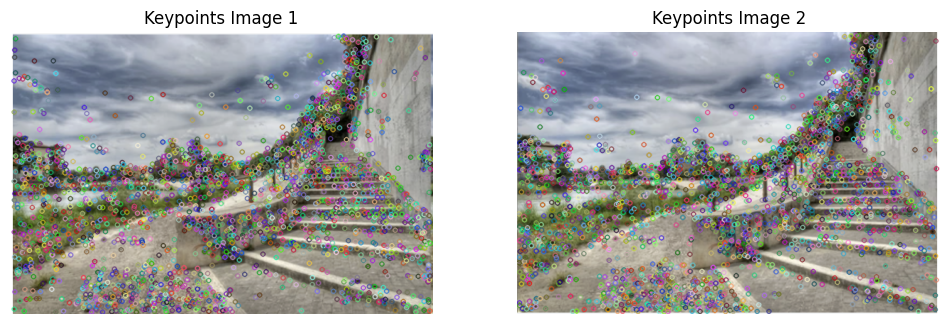

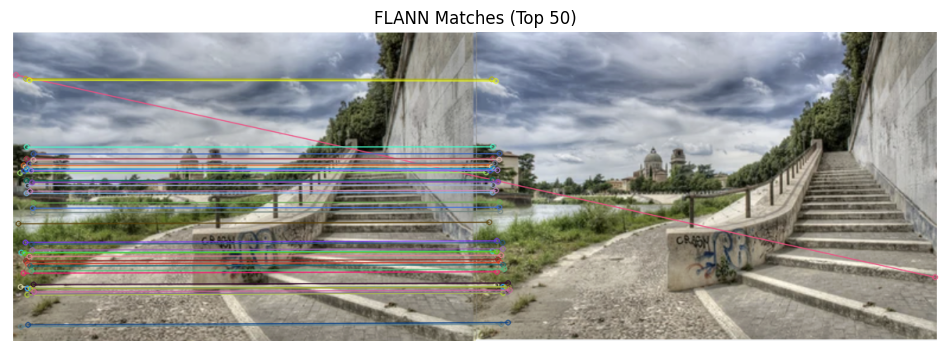

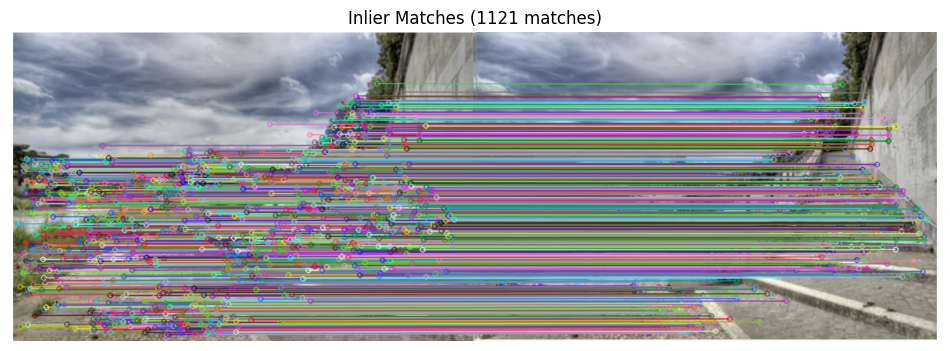

Fundamental Matrix F:
 [[ 8.31595361e-08 -8.77521527e-05  1.30217459e-02]
 [ 9.39153313e-05  1.33859415e-05 -1.48388704e-01]
 [-1.41422948e-02  1.40409590e-01  1.00000000e+00]]
Rotation Matrix R:
 [[ 0.99953486  0.01914146  0.02374162]
 [-0.0199103   0.99927074  0.03258157]
 [-0.02310064 -0.03303912  0.99918706]]
Translation Vector t:
 [[-0.8556075 ]
 [ 0.03154961]
 [-0.51666279]]


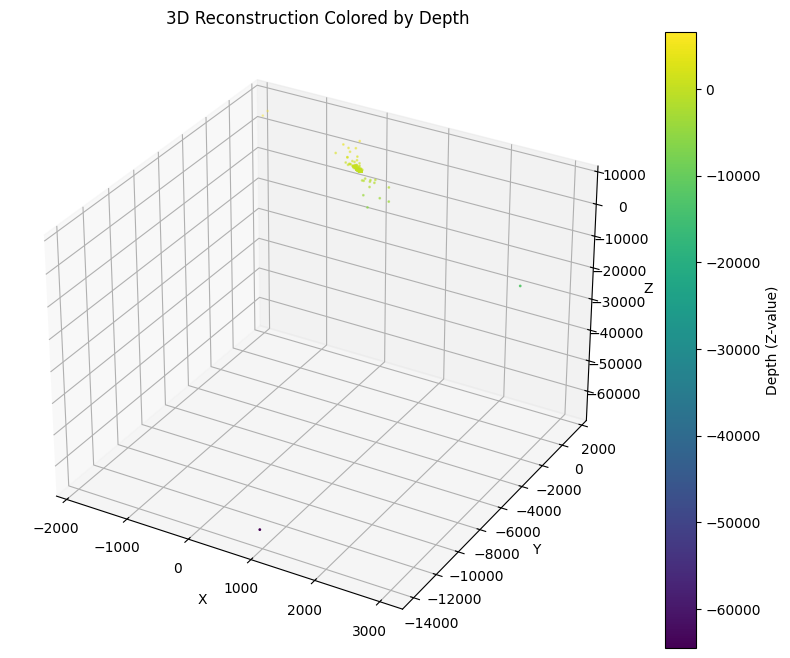

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------
# 1. Load images and grayscale
# -------------------------------
img1 = cv2.imread("/Users/sharo2/Labs/sift_lab/left.png")
img2 = cv2.imread("/Users/sharo2/Labs/sift_lab/right.png")

if img1 is None or img2 is None:
    raise FileNotFoundError("Cannot load images. Check paths!")

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# -------------------------------
# 2. SIFT keypoints and descriptors
# -------------------------------
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Visualize keypoints
img_kp1 = cv2.drawKeypoints(img1, kp1, None)
img_kp2 = cv2.drawKeypoints(img2, kp2, None)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_kp1, cv2.COLOR_BGR2RGB))
plt.title("Keypoints Image 1")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_kp2, cv2.COLOR_BGR2RGB))
plt.title("Keypoints Image 2")
plt.axis('off')
plt.show()

# -------------------------------
# 3. Feature Matching (FLANN)
# -------------------------------
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches_knn = flann.knnMatch(des1, des2, k=2)
good_matches = [m for m,n in matches_knn if m.distance < 0.7*n.distance]

# Draw matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[:50], None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("FLANN Matches (Top 50)")
plt.axis('off')
plt.show()

# -------------------------------
# 4. Fundamental Matrix + RANSAC
# -------------------------------
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1.0)
inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]

# Draw inlier matches
img_inliers = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(img_inliers, cv2.COLOR_BGR2RGB))
plt.title(f"Inlier Matches ({len(inlier_matches)} matches)")
plt.axis('off')
plt.show()

print("Fundamental Matrix F:\n", F)

# -------------------------------
# 5. Essential Matrix & Camera Pose
# -------------------------------
f, cx, cy = 800, img1.shape[1]//2, img1.shape[0]//2
K = np.array([[f, 0, cx],
              [0, f, cy],
              [0, 0, 1]])
E = K.T @ F @ K

pts1_inliers = np.float32([kp1[m.queryIdx].pt for i, m in enumerate(good_matches) if mask[i]])
pts2_inliers = np.float32([kp2[m.trainIdx].pt for i, m in enumerate(good_matches) if mask[i]])

_, R, t, _ = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)
print("Rotation Matrix R:\n", R)
print("Translation Vector t:\n", t)

# -------------------------------
# 6. Triangulation
# -------------------------------
P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = K @ np.hstack((R, t))

points_4d_hom = cv2.triangulatePoints(P1, P2, pts1_inliers.T, pts2_inliers.T)
points_3d = points_4d_hom[:3] / points_4d_hom[3]

# -------------------------------
# 7. 3D Visualization Colored by Depth
# -------------------------------
x, y, z = points_3d[0], points_3d[1], points_3d[2]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=1)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('3D Reconstruction Colored by Depth')
plt.colorbar(sc, label='Depth (Z-value)')
plt.show()
